In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import typing as t
import pandas as pd
import seaborn as sns
from weatherbench2 import schema
#from weatherbench2.derived_variables import ZonalEnergySpectrum

In [2]:
class DerivedVariable:
  """Derived variable base class."""

  @property
  def base_variables(self) -> list[str]:
    """Return a list of base variables."""
    return []

  @property
  def core_dims(self) -> t.Tuple[t.Tuple[t.List[str], ...], t.List[str]]:
    """Return core dimensions needed for computing this variable.

    Returns a tuple, where the first element is a tuple of all core dimensions
    for input (base) variables, and the second element is a tuple of all core
    dimensions on the output. For more details on the concept of "core
    dimensions", see xarray.apply_ufunc.
    """
    raise NotImplementedError

  @property
  def all_input_core_dims(self) -> set[str]:
    """The set of all input core dimensions."""
    return set().union(*self.core_dims[0])

  def compute(self, dataset: xr.Dataset) -> xr.DataArray:
    """Compute derived variable, returning it in a new DataArray."""
    raise NotImplementedError

In [3]:
class ZonalEnergySpectrum_local(DerivedVariable):
  """Energy spectrum along the zonal direction.

  Given dataset with longitude dimension, this class computes spectral energy as
  a function of wavenumber (as a dim). wavelength and frequency are also present
  as coords with units "1 / m" and "m" respectively. Only non-negative
  frequencies are included.

  Let f[l], l = 0,..., L - 1, be dataset values along a zonal circle of constant
  latitude, with circumference C (m).  The DFT is
    F[k] = (1 / L) Σₗ f[l] exp(-i2πkl/L)
  The energy spectrum is then set to
    S[0] = C |F[0]|²,
    S[k] = 2 C |F[k]|², k > 0, to account for positive and negative frequencies.

  With C₀ the equatorial circumference, the ith zonal circle has circumference
    C(i) = C₀ Cos(π latitude[i] / 180).
  Since data points occur at longitudes longitude[l], l = 0, ..., L - 1, the DFT
  will measure spectra at zonal sampling frequencies
    f(k, i) = longitude[k] / (C(i) 360), k = 0, ..., L // 2,
  and corresponding wavelengths
    λ(k, i) = 1 / f(k, i).

  This choice of normalization ensures Parseval's relation for energy holds:
  Supposing f[l] are sampled values of f(ℓ), where 0 < ℓ < C (meters) is a
  coordinate on the circle. Then (C / L) is the spacing of longitudinal samples,
  whence
    ∫|f(ℓ)|² dℓ ≈ (C / L) Σₗ |f[l]|² = Σₖ S[k].

  If f has units β, then S has units of m β². For example, if f is
  `u_component_of_wind`, with units (m / s), then S has units (m³ / s²). In
  air with mass density ρ (kg / m³), this gives energy density at wavenumber k
    ρ S[k] ~ (kg / m³) (m³ / s²) = kg / s²,
  which is energy density (per unit area).
  """

  variable_name: str

  @property
  def base_variables(self) -> list[str]:
    return [self.variable_name]

  @property
  def core_dims(self) -> t.Tuple[t.Tuple[t.List[str], ...], t.List[str]]:
    return (['longitude'],), ['zonal_wavenumber']

  def _circumference(self, dataset: xr.Dataset) -> xr.DataArray:
    """Earth's circumference as a function of latitude."""
    circum_at_equator = 2 * np.pi * schema.EARTH_RADIUS_M
    return np.cos(dataset.latitude * np.pi / 180) * circum_at_equator

  def lon_spacing_m(self, dataset: xr.Dataset) -> xr.DataArray:
    """Spacing (meters) between longitudinal values in `dataset`."""
    diffs = dataset.longitude.diff('longitude')
    if np.max(np.abs(diffs - diffs[0])) > 1e-3:
      raise ValueError(
          f'Expected uniform longitude spacing. {dataset.longitude.values=}'
      )
    return self._circumference(dataset) * diffs[0].data / 360

  def compute(self, dataset: xr.Dataset) -> xr.DataArray:
    """Computes zonal power at wavenumber and frequency."""
    spacing = self.lon_spacing_m(dataset)

    def simple_power(f_x):
      f_k = np.fft.rfft(f_x, axis=-1, norm='forward')
      # freq > 0 should be counted twice in power since it accounts for both
      # positive and negative complex values.
      one_and_many_twos = np.concatenate(([1], [2] * (f_k.shape[-1] - 1)))
      return np.real(f_k * np.conj(f_k)) * one_and_many_twos

    spectrum = xr.apply_ufunc(
        simple_power,
        dataset,
        input_core_dims=[['longitude']],
        output_core_dims=[['longitude']],
        exclude_dims={'longitude'},
    ).rename_dims({'longitude': 'zonal_wavenumber'})#[self.variable_name]
    spectrum = spectrum.assign_coords(
        zonal_wavenumber=('zonal_wavenumber', spectrum.zonal_wavenumber.data)
    )
    base_frequency = xr.DataArray(
        np.fft.rfftfreq(len(dataset.longitude)),
        dims='zonal_wavenumber',
        coords={'zonal_wavenumber': spectrum.zonal_wavenumber},
    )
    spectrum = spectrum.assign_coords(frequency=base_frequency / spacing)
    spectrum['frequency'] = spectrum.frequency.assign_attrs(units='1 / m')

    spectrum = spectrum.assign_coords(wavelength=1 / spectrum.frequency)
    spectrum['wavelength'] = spectrum.wavelength.assign_attrs(units='m')

    # This last step ensures the sum of spectral components is equal to the
    # (discrete) integral of data around a line of latitude.
    return spectrum * self._circumference(spectrum)

In [4]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [5]:
start_date = "2022-01-01T00"
end_date = "2022-01-31T21"

dates_3hr = pd.date_range(
    start_date,
    end_date,
    freq="3h",
)

dates_6hr = pd.date_range(
    start_date,
    end_date,
    freq="6h",
)

In [6]:
varlist = [
    "tmp",
    "ugrd",
    "vgrd",
    "dzdt",
    "spfh",
    "tmp2m",
    "pressfc",
    "ugrd10m",
    "vgrd10m",
    "geopotential",
    # additions 
    "spfh2m",
    "tmpsfc",
]

In [7]:
selected_levels = (676, 773, 1000)

In [8]:
# Open the atm zarr-store
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

In [9]:
rds = rds[varlist]
rds_3hr = rds.sel(time=dates_3hr)
rds_6hr = rds.sel(time=dates_6hr)

rds_3hr = rds_3hr.sel(pfull=list(selected_levels), method="nearest")
rds_6hr = rds_6hr.sel(pfull=list(selected_levels), method="nearest")

In [10]:
%%time
rds_3hr = rds_3hr.load()
rds_6hr = rds_6hr.load()

CPU times: user 2min 6s, sys: 1min 35s, total: 3min 41s
Wall time: 1min 49s


In [11]:
rds_3hr

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 248, pfull: 3, grid_yt: 192, grid_xt: 384)
Coordinates:
    cftime        (time) object 2kB 2022-01-01 00:00:00 ... 2022-01-31 21:00:00
    ftime         (time) timedelta64[ns] 2kB -1 days +18:00:00 ... -1 days +2...
  * grid_xt       (grid_xt) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * grid_yt       (grid_yt) float64 2kB 89.82 88.89 87.95 ... -88.18 -89.12
  * pfull         (pfull) float32 12B 669.1 768.0 998.8
  * time          (time) datetime64[ns] 2kB 2022-01-01 ... 2022-01-31T21:00:00
Data variables:
    tmp           (time, pfull, grid_yt, grid_xt) float32 219MB 247.9 ... 241.9
    ugrd          (time, pfull, grid_yt, grid_xt) float32 219MB -4.982 ... -3...
    vgrd          (time, pfull, grid_yt, grid_xt) float32 219MB 10.33 ... -2.437
    dzdt          (time, pfull, grid_yt, grid_xt) float32 219MB -0.01086 ... ...
    spfh          (time, pfull, grid_yt, grid_xt) float32 219MB 0.0002538 ......
    tmp2m         (time, grid_yt, grid_xt) float32 73MB 249.2 249.2 ... 241.7
    pressfc       (time, grid_yt, grid_xt) float32 73MB 1.03e+05 ... 7.027e+04
    ugrd10m       (time, grid_yt, grid_xt) float32 73MB -2.38 -2.324 ... -3.966
    vgrd10m       (time, grid_yt, grid_xt) float32 73MB 3.401 3.44 ... -2.486
    geopotential  (time, pfull, grid_yt, grid_xt) float32 219MB 2.932e+04 ......
    spfh2m        (time, grid_yt, grid_xt) float32 73MB 0.0004128 ... 0.0002611
    tmpsfc        (time, grid_yt, grid_xt) float32 73MB 246.8 246.8 ... 240.8
Attributes:
    abstract:         The NOAA Unified Forecast System (UFS) / Global Ensembl...
    acknowledgement:  To provide appropriate attribution under this license, ...
    description:      This zarr store is a subset of the original GEFSv13 UFS...
    license:          The Global Ensemble Forecast System version 13 (GEFSv13...

In [12]:
rds_6hr

<xarray.Dataset> Size: 878MB
Dimensions:       (time: 124, pfull: 3, grid_yt: 192, grid_xt: 384)
Coordinates:
    cftime        (time) object 992B 2022-01-01 00:00:00 ... 2022-01-31 18:00:00
    ftime         (time) timedelta64[ns] 992B -1 days +18:00:00 ... -1 days +...
  * grid_xt       (grid_xt) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * grid_yt       (grid_yt) float64 2kB 89.82 88.89 87.95 ... -88.18 -89.12
  * pfull         (pfull) float32 12B 669.1 768.0 998.8
  * time          (time) datetime64[ns] 992B 2022-01-01 ... 2022-01-31T18:00:00
Data variables:
    tmp           (time, pfull, grid_yt, grid_xt) float32 110MB 247.9 ... 242.1
    ugrd          (time, pfull, grid_yt, grid_xt) float32 110MB -4.982 ... -3...
    vgrd          (time, pfull, grid_yt, grid_xt) float32 110MB 10.33 ... -2.582
    dzdt          (time, pfull, grid_yt, grid_xt) float32 110MB -0.01086 ... ...
    spfh          (time, pfull, grid_yt, grid_xt) float32 110MB 0.0002538 ......
    tmp2m         (time, grid_yt, grid_xt) float32 37MB 249.2 249.2 ... 242.0
    pressfc       (time, grid_yt, grid_xt) float32 37MB 1.03e+05 ... 7.021e+04
    ugrd10m       (time, grid_yt, grid_xt) float32 37MB -2.38 -2.324 ... -3.714
    vgrd10m       (time, grid_yt, grid_xt) float32 37MB 3.401 3.44 ... -2.647
    geopotential  (time, pfull, grid_yt, grid_xt) float32 110MB 2.932e+04 ......
    spfh2m        (time, grid_yt, grid_xt) float32 37MB 0.0004128 ... 0.0002756
    tmpsfc        (time, grid_yt, grid_xt) float32 37MB 246.8 246.8 ... 241.3
Attributes:
    abstract:         The NOAA Unified Forecast System (UFS) / Global Ensembl...
    acknowledgement:  To provide appropriate attribution under this license, ...
    description:      This zarr store is a subset of the original GEFSv13 UFS...
    license:          The Global Ensemble Forecast System version 13 (GEFSv13...

## Spectra

In [13]:
fig_dir_loc = "./figures"

In [14]:
zspec = ZonalEnergySpectrum_local()
spectra_3hr = zspec.compute(dataset = rds_3hr.diff("time").rename({"grid_yt":"latitude","grid_xt":"longitude"}))
spectra_6hr = zspec.compute(dataset = rds_6hr.diff("time").rename({"grid_yt":"latitude","grid_xt":"longitude"}))

In [15]:
spectra_3hr

<xarray.Dataset> Size: 2GB
Dimensions:           (time: 247, latitude: 192, pfull: 3, zonal_wavenumber: 193)
Coordinates:
    cftime            (time) object 2kB 2022-01-01 03:00:00 ... 2022-01-31 21...
    ftime             (time) timedelta64[ns] 2kB -1 days +21:00:00 ... -1 day...
  * latitude          (latitude) float64 2kB 89.82 88.89 87.95 ... -88.18 -89.12
  * pfull             (pfull) float32 12B 669.1 768.0 998.8
  * time              (time) datetime64[ns] 2kB 2022-01-01T03:00:00 ... 2022-...
  * zonal_wavenumber  (zonal_wavenumber) int64 2kB 0 1 2 3 4 ... 189 190 191 192
    frequency         (zonal_wavenumber, latitude) float64 296kB 0.0 ... 0.00...
    wavelength        (zonal_wavenumber, latitude) float64 296kB inf ... 3.19...
Data variables:
    tmp               (time, pfull, latitude, zonal_wavenumber) float64 220MB ...
    ugrd              (time, pfull, latitude, zonal_wavenumber) float64 220MB ...
    vgrd              (time, pfull, latitude, zonal_wavenumber) float64 220MB ...
    dzdt              (time, pfull, latitude, zonal_wavenumber) float64 220MB ...
    spfh              (time, pfull, latitude, zonal_wavenumber) float64 220MB ...
    tmp2m             (time, latitude, zonal_wavenumber) float64 73MB 450.1 ....
    pressfc           (time, latitude, zonal_wavenumber) float64 73MB 1.546e+...
    ugrd10m           (time, latitude, zonal_wavenumber) float64 73MB 1.913e+...
    vgrd10m           (time, latitude, zonal_wavenumber) float64 73MB 88.13 ....
    geopotential      (time, pfull, latitude, zonal_wavenumber) float64 220MB ...
    spfh2m            (time, latitude, zonal_wavenumber) float64 73MB 7.05e-0...
    tmpsfc            (time, latitude, zonal_wavenumber) float64 73MB 5.254e+...

In [16]:
spectra_6hr

<xarray.Dataset> Size: 876MB
Dimensions:           (time: 123, latitude: 192, pfull: 3, zonal_wavenumber: 193)
Coordinates:
    cftime            (time) object 984B 2022-01-01 06:00:00 ... 2022-01-31 1...
    ftime             (time) timedelta64[ns] 984B -1 days +18:00:00 ... -1 da...
  * latitude          (latitude) float64 2kB 89.82 88.89 87.95 ... -88.18 -89.12
  * pfull             (pfull) float32 12B 669.1 768.0 998.8
  * time              (time) datetime64[ns] 984B 2022-01-01T06:00:00 ... 2022...
  * zonal_wavenumber  (zonal_wavenumber) int64 2kB 0 1 2 3 4 ... 189 190 191 192
    frequency         (zonal_wavenumber, latitude) float64 296kB 0.0 ... 0.00...
    wavelength        (zonal_wavenumber, latitude) float64 296kB inf ... 3.19...
Data variables:
    tmp               (time, pfull, latitude, zonal_wavenumber) float64 109MB ...
    ugrd              (time, pfull, latitude, zonal_wavenumber) float64 109MB ...
    vgrd              (time, pfull, latitude, zonal_wavenumber) float64 109MB ...
    dzdt              (time, pfull, latitude, zonal_wavenumber) float64 109MB ...
    spfh              (time, pfull, latitude, zonal_wavenumber) float64 109MB ...
    tmp2m             (time, latitude, zonal_wavenumber) float64 36MB 2.805e+...
    pressfc           (time, latitude, zonal_wavenumber) float64 36MB 5.095e+...
    ugrd10m           (time, latitude, zonal_wavenumber) float64 36MB 7.063e+...
    vgrd10m           (time, latitude, zonal_wavenumber) float64 36MB 149.7 ....
    geopotential      (time, pfull, latitude, zonal_wavenumber) float64 109MB ...
    spfh2m            (time, latitude, zonal_wavenumber) float64 36MB 4.618e-...
    tmpsfc            (time, latitude, zonal_wavenumber) float64 36MB 7.697e+...

In [17]:
def get_save_kwargs(fhr, use_seaborn, show_diff, zoom):
    fname = f"{fig_dir_loc}/spectra_surface_{fhr:03d}h"
    if zoom: 
        fname += "_zoom"
    if use_seaborn:
        fname += "_ci"
    if show_diff:
        fname + "_diff"
    fname += ".jpeg"
    return {"fname": fname, "bbox_inches": "tight", "dpi": 300}

In [18]:
def plot_spectra_2d(
    spectra_3hr,
    spectra_6hr = None,
    ax = None,
    fields=("tmp2m", "spfh2m", "ugrd10m", "vgrd10m", "pressfc"),
    labels=("2m_temperature", "2m_specific_humidity" , "10m_u_component_of_wind", "10m_v_component_of_wind", "surface_pressure"),
    use_seaborn=False,
    zoom=False,
    save=False,
):
    ncols = len(fields)
    if ax is None:
        fig, axs = plt.subplots(1, ncols, figsize=(ncols*4, 4), constrained_layout=True)

    for i, (fld, ax) in enumerate(zip(fields, axs)):
        
        kw = {
            "ax": ax,
            "x": "zonal_wavenumber",
            "linewidth": 2,
        }
        if fld in spectra_3hr:
            plotme_3hr = spectra_3hr[fld]
            if spectra_6hr is not None:
                plotme_6hr = spectra_6hr[fld] 
            
        if use_seaborn:
            sns.lineplot(
                data=plotme_3hr.to_dataframe().reset_index(),
                y=fld,
                legend=False,
                color="r"
                **kw,
            )
            if spectra_6hr is not None:
                sns.lineplot(
                    data=plotme_6hr.to_dataframe().reset_index(),
                    y=fld,
                    legend=False,
                    color="b"
                    **kw,
                )
        else:
            plotme_3hr.mean("latitude").plot(color="r", label="3 hour", **kw)
            if spectra_6hr is not None:
                plotme_6hr.mean("latitude").plot(color="b", label="6 hour", **kw)
        
        title = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
        zkw = {}
        if zoom:
            zkw = {"ylim": [None, 1e6], "xlim": [1e1, None]}
        else:
            if fld == "2m_temperature":
                zkw = {"ylim": [None, 1e9]}
        ax.set(
            xlabel="Zonal Wavenumber",
            ylabel="",
            title=title,
            xscale="log",
            yscale="log",
            **zkw,
        )
        for key in ["right", "top"]:
            ax.spines[key].set_visible(False)

    if save:
        fig.savefig(**get_save_kwargs(fhr=fhr, zoom=zoom))
    return fig, axs

In [19]:
kw = {
    "use_seaborn": False,
    "zoom": False,
    "save": False,
}

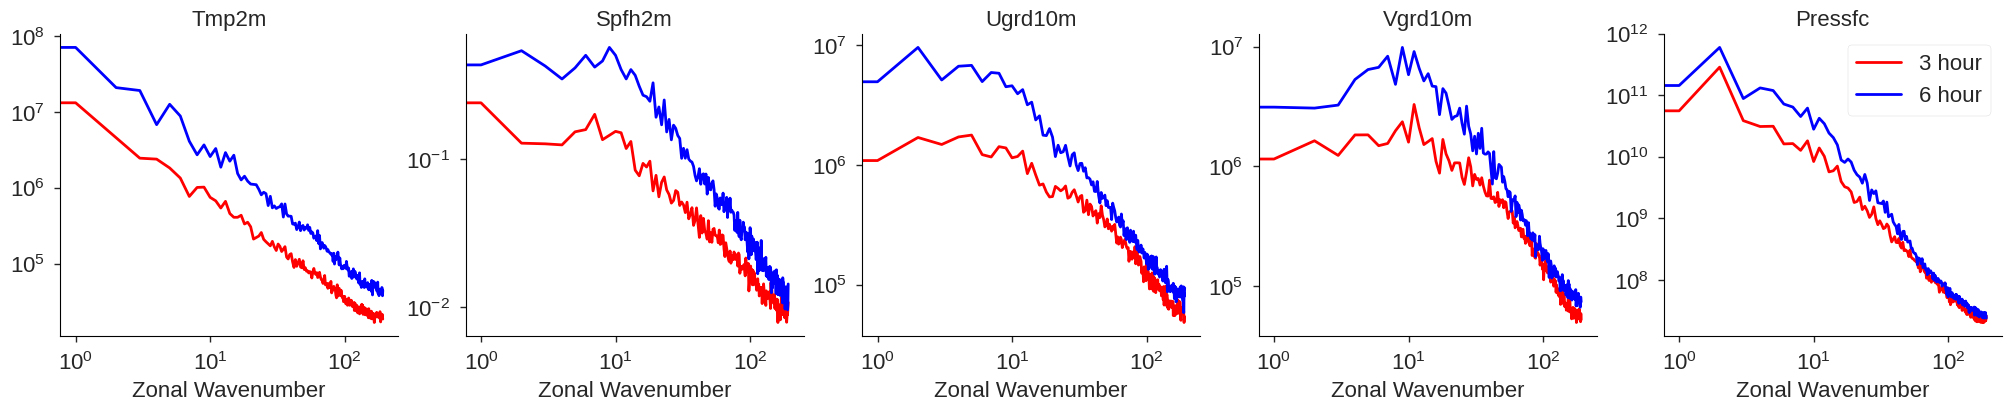

In [20]:
fig, axs = plot_spectra_2d(spectra_3hr.isel(time=-1), spectra_6hr.isel(time=-1), **kw)
plt.legend()
plt.show()

In [21]:
def plot_spectra_3d(
    spectra_3hr,
    spectra_6hr = None,
    axs = None,
    fields=("tmp", "spfh", "ugrd", "vgrd", "dzdt", "geopotential"),
    labels=("2m_temperature", "2m_specific_humidity" , "u_component_of_wind", "v_component_of_wind", "vertical_velocity", "geopotential"),
    use_seaborn=False,
    zoom=False,
    save=False,
):
    ncols = len(fields)
    nrows = spectra_3hr.sizes["pfull"]
    
    if axs is None:
        fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, 4*nrows), constrained_layout=True)

    for i in range(nrows):
        
        for j, fld in enumerate(fields):
            ax = axs[i,j]
            
            kw = {
                "ax": ax,
                "x": "zonal_wavenumber",
                "linewidth": 2,
            }
            if fld in spectra_3hr:
                plotme_3hr = spectra_3hr[fld].isel(pfull=i)
                if spectra_6hr is not None:
                    plotme_6hr = spectra_6hr[fld].isel(pfull=i) 
            
            if use_seaborn:
                sns.lineplot(
                    data=plotme_3hr.to_dataframe().reset_index(),
                    y=fld,
                    legend=False,
                    color="r"
                    **kw,
                )
                if spectra_6hr is not None:
                    sns.lineplot(
                        data=plotme_6hr.to_dataframe().reset_index(),
                        y=fld,
                        legend=False,
                        color="b"
                        **kw,
                    )
            else:
                plotme_3hr.mean("latitude").plot(color="r", label="3 hour", **kw)
                if spectra_6hr is not None:
                    plotme_6hr.mean("latitude").plot(color="b", label="6 hour", **kw)
        
            title = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
            zkw = {}
            if zoom:
                zkw = {"ylim": [None, 1e6], "xlim": [1e1, None]}
            else:
                if fld == "2m_temperature":
                    zkw = {"ylim": [None, 1e9]}
            ax.set(
                ylabel="",
                title="",
                xlabel="",
                xscale="log",
                yscale="log",
                **zkw,
            )
            if i==0:
                ax.set(
                    title=title,
                )
            if i == nrows-1:
                ax.set(
                    xlabel="Zonal Wavenumber",
                )
            if  j == 0:
                ax.set(
                    ylabel=f"{spectra_3hr.coords['pfull'][i].values:.02f}",
                )
            for key in ["right", "top"]:
                ax.spines[key].set_visible(False)
                
    if save:
        fig.savefig(**get_save_kwargs(fhr=fhr, zoom=zoom))
    return fig, axs

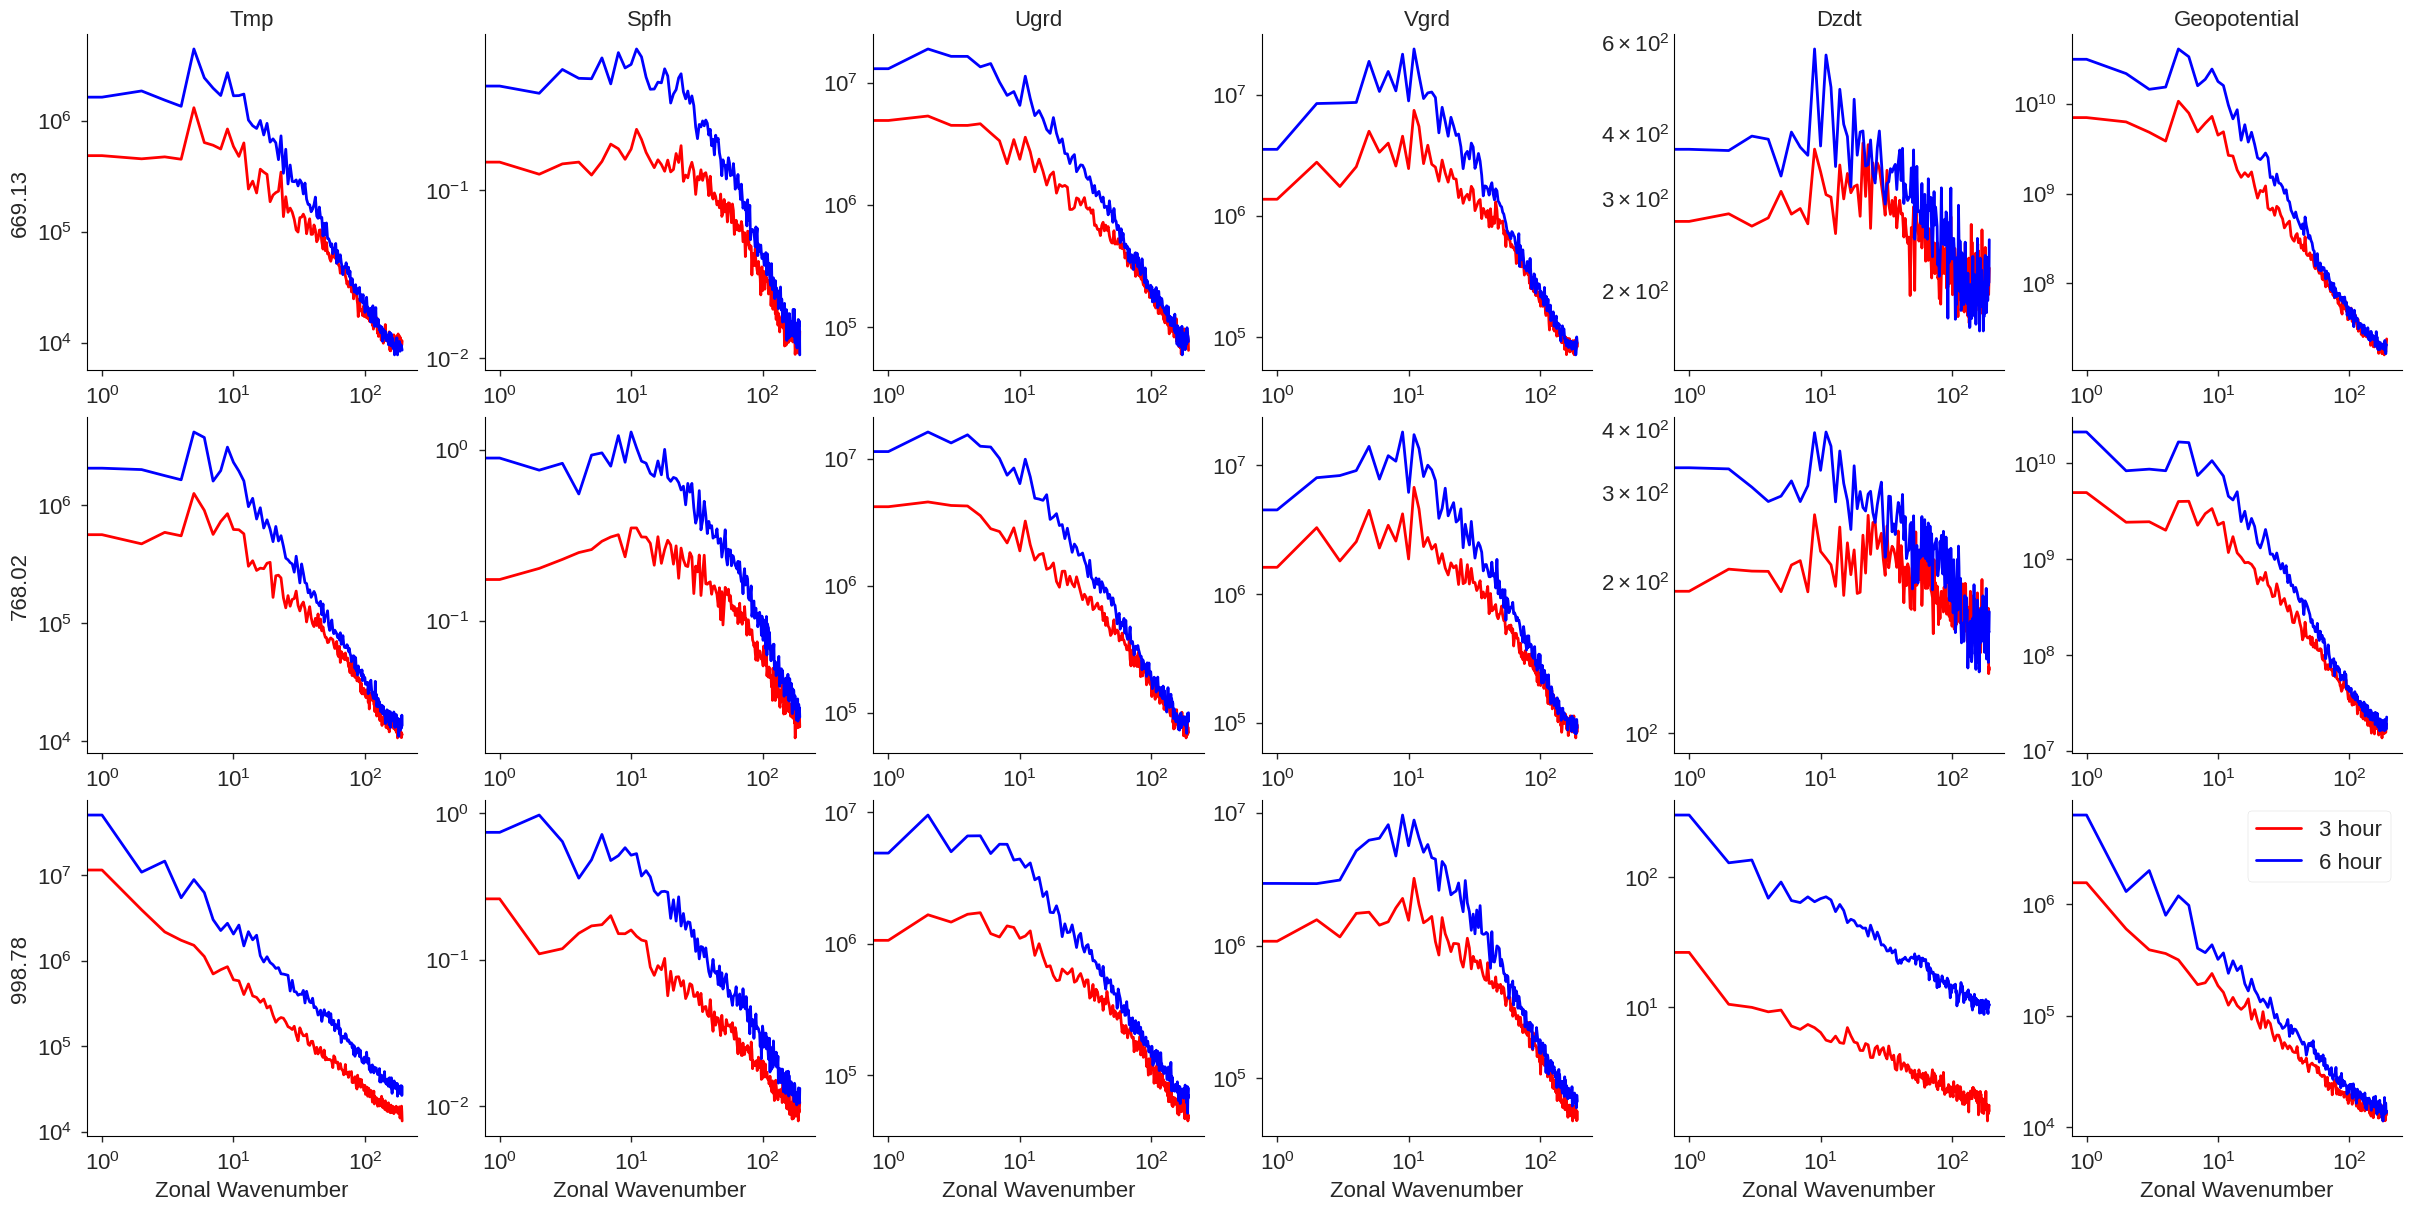

In [22]:
fig, axs = plot_spectra_3d(spectra_3hr.isel(time=-1), spectra_6hr.isel(time=-1), **kw)
plt.legend()
plt.show()

Text(0.5, 0.98, 'Specific Humidity Top Level')

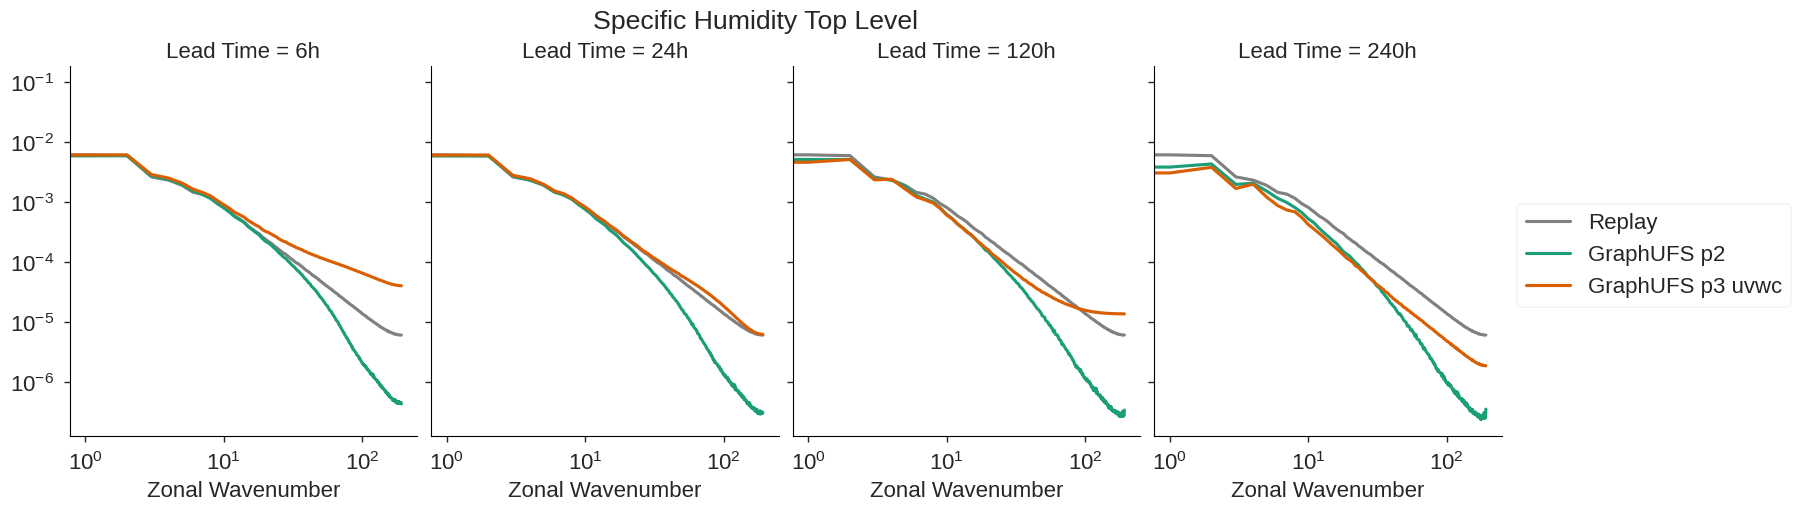

In [19]:
fldname = "specific_humidity"
fhrs = [6, 24, 120, 240]
fig, axs = plt.subplots(1, 4, figsize=(15,5), constrained_layout=True, sharey=True)
keylist = [key for key in spectra.keys() if key != "GraphCast" and key != "Replay"]

for ax in axs:
    plotme = spectra["Replay"][fldname].sel(level=226,method='nearest').mean("latitude")
    plotme.plot(ax=ax, color="Gray", label="Replay" if ax.get_subplotspec().is_first_col() else None)
    ax.set(ylabel="", title="")
    
for key in keylist:
    plotme = spectra[key][fldname]
    plotme = plotme.sel(level=226, method="nearest")
    plotme = plotme.mean("latitude")
    for fhr, ax in zip(fhrs, axs):
        plotme.sel(fhr=fhr).plot(
            ax=ax,
            yscale="log",
            xscale="log",
            label=key if ax.get_subplotspec().is_first_col() else None,
        )

for fhr, ax in zip(fhrs, axs):
    ax.set(xlabel="Zonal Wavenumber", ylabel="", title=f"Lead Time = {fhr}h")

fig.legend(loc="center left", bbox_to_anchor=(1, .5))
fig.suptitle(" ".join([x.capitalize() if x != "of" else x for x in fldname.split("_")])+ " Top Level")